In [1]:
import deepchem as dc

import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data = pd.read_csv('BST.csv',encoding = 'gb2312')

In [3]:
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
features = featurizer.featurize(data['SMILES'])

In [4]:
dataset_y = [ast.literal_eval(label) for label in data['Label']]
dataset_new_y = MultiLabelBinarizer().fit_transform(dataset_y)

In [5]:
dataset = dc.data.NumpyDataset(X=features, y=dataset_new_y.astype(np.float32),ids=data["SMILES"])

In [6]:
splitter = dc.splits.ScaffoldSplitter()
train_dataset,valid_dataset,test_dataset = splitter.train_valid_test_split(dataset=dataset,frac_train=0.7,frac_valid=0.1,frac_test=0.2,seed=200)

In [7]:
model = dc.models.torch_models.AttentiveFPModel(
    n_tasks=3,
    batch_size=32,
    learning_rate=0.0001,
    use_queue=False,
    mode='classification')

In [8]:
loss =  model.fit(train_dataset, nb_epoch=200)

In [9]:
loss

0.018507817983627318

# 验证集

In [10]:
y_pred_val = model.predict(valid_dataset)
y_pred_val = np.round(y_pred_val).astype(int)
y_pred_val = y_pred_val[:, :, 1]
y_pred_val

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [11]:
valid_dataset.y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [12]:
# 计算评估指标
val_f1 = f1_score(valid_dataset.y,y_pred_val, average='macro')
val_accuracy = accuracy_score(valid_dataset.y, y_pred_val)
val_recall = recall_score(valid_dataset.y, y_pred_val, average='macro')
val_precision = precision_score(valid_dataset.y, y_pred_val, average='macro')

# 输出评估指标
print('F1 score:', val_f1)
print('Accuracy:', val_accuracy)
print('Recall:', val_recall)
print('Precision:', val_precision)

F1 score: 0.7926197625080594
Accuracy: 0.8302611367127496
Recall: 0.8086854137900428
Precision: 0.7810866698426507


# 测试集

In [13]:
y_pred_test = model.predict(test_dataset)
y_pred_test = np.round(y_pred_test).astype(int)
y_pred_test = y_pred_test[:, :, 1]
y_pred_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [14]:
# 将真实标签和预测标签转换为整数形式
y_true = np.argmax(test_dataset.y, axis=1)
y_pred = np.argmax(y_pred_test, axis=1)

In [15]:
# 将标签转换为整数形式
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(y_true)
y_pred = label_encoder.transform(y_pred)

In [17]:
cm = confusion_matrix(y_true, y_pred)

In [18]:
cm

array([[ 493,   62,  165],
       [  50,  326,   37],
       [ 295,   56, 1120]], dtype=int64)

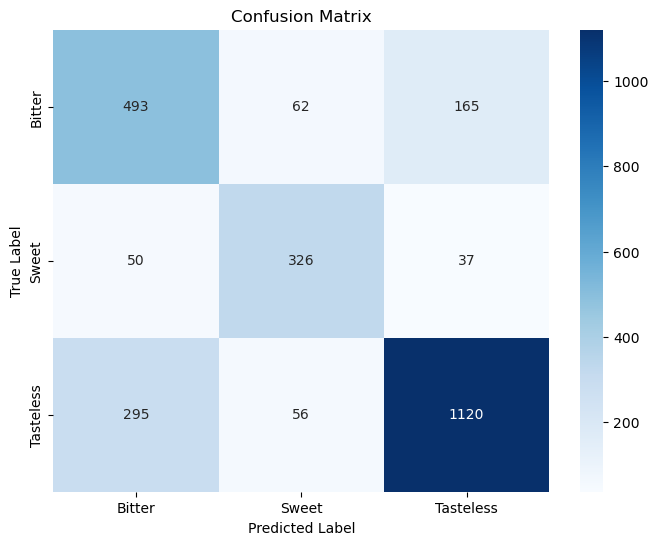

In [19]:
class_names = label_encoder.classes_  # 类别名称

# 绘制混淆矩阵图
class_names = ['Bitter', 'Sweet', 'Tasteless']  # 类别名称

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
# 计算评估指标
test_f1 = f1_score(test_dataset.y,y_pred_test, average='macro')
test_accuracy = accuracy_score(test_dataset.y, y_pred_test)
test_recall = recall_score(test_dataset.y, y_pred_test, average='macro')
test_precision = precision_score(test_dataset.y, y_pred_test, average='macro')

# 输出评估指标
print('F1 score:', test_f1)
print('Accuracy:', test_accuracy)
print('Recall:', test_recall)
print('Precision:', test_precision)

F1 score: 0.7309890973202338
Accuracy: 0.7142857142857143
Recall: 0.730238093104355
Precision: 0.734307538265652
